In [138]:
import pandas as pd
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [139]:
def display_scrollable_df(df, max_rows=5, height=300):
    display(HTML(df.head(max_rows).to_html(max_rows=max_rows, max_cols=100, escape=False)))
    display(HTML(f"""<style>
        .output_scroll {{
            max-height: {height}px;
            overflow-y: auto;
        }}
    </style>"""))

In [140]:
# Load Dataset 1 - Stock Portfolio Data with Process and Indices
portfolio_path = r"C:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\Stock Portfolio Data with Prices and Indices"

portfolio_df = pd.read_csv(os.path.join(portfolio_path, "portfolio.csv"))
portfolio_prices_df = pd.read_csv(os.path.join(portfolio_path, "portfolio_prices.csv"))
nasdaq_df = pd.read_csv(os.path.join(portfolio_path, "NASDAQ.csv"))
dow_jones_df = pd.read_csv(os.path.join(portfolio_path, "dow_jones.csv"))
sp500_df = pd.read_csv(os.path.join(portfolio_path, "sp500.csv"))

print("Stock Portfolio Data with Prices and Indices Dataset:")

print("\nPortfolio:")
display_scrollable_df(portfolio_df.head())

print("\nPortfolio Prices:")
display_scrollable_df(portfolio_prices_df.head())

print("\nNASDAQ:")
display_scrollable_df(nasdaq_df.head())

print("\nDow Jones:")
display_scrollable_df(dow_jones_df.head())

print("\nS&P 500:")
display_scrollable_df(sp500_df.head())


Stock Portfolio Data with Prices and Indices Dataset:

Portfolio:


,Ticker,Quantity,Sector,Close,Weight
0,AAPL,1,IT,218.270004,3.461290
1,ADAP,1,Pharmaceuticals,0.291000,0.004615
2,AGCO,1,Agriculture,93.089996,1.476206
3,BA,2,Military Engineering,178.110001,2.824439
4,BG,4,Agriculture,73.250000,1.161586



Portfolio Prices:


,Date,Ticker,Open,High,Low,Close,Adjusted,Returns,Volume
0,2020-01-03,JPM,137.500000,139.229996,137.080002,138.339996,119.874138,-0.013197,10386800
1,2020-01-03,KO,54.320000,54.990002,54.090000,54.689999,46.494698,-0.005455,11354500
2,2020-01-03,LMT,404.019989,417.170013,403.000000,413.739990,359.312317,0.035981,2990100
3,2020-01-03,MS,51.220001,51.450001,50.830002,51.200001,43.273079,-0.016142,6706000
4,2020-01-03,MSCI,262.200012,263.579987,259.269989,260.750000,248.019470,-0.019921,459700



NASDAQ:


,Date,Ticker,Open,High,Low,Close,Adjusted,Returns,Volume
0,2020-01-02,IXIC,9039.459961,9093.429688,9010.889648,9092.190430,9092.190430,NaN,2862700000
1,2020-01-03,IXIC,8976.429688,9065.759766,8976.429688,9020.769531,9020.769531,-0.007855,2586520000
2,2020-01-06,IXIC,8943.500000,9072.410156,8943.500000,9071.469727,9071.469727,0.005620,2810450000
3,2020-01-07,IXIC,9076.639648,9091.929688,9042.549805,9068.580078,9068.580078,-0.000319,2381740000
4,2020-01-08,IXIC,9068.030273,9168.889648,9059.379883,9129.240234,9129.240234,0.006689,2472620000



Dow Jones:


,Date,Ticker,Open,High,Low,Close,Adjusted,Returns,Volume
0,2020-01-02,DJI,28638.970703,28872.800781,28627.769531,28868.800781,28868.800781,NaN,251820000
1,2020-01-03,DJI,28553.330078,28716.310547,28500.359375,28634.880859,28634.880859,-0.008103,239590000
2,2020-01-06,DJI,28465.500000,28708.019531,28418.630859,28703.380859,28703.380859,0.002392,252760000
3,2020-01-07,DJI,28639.179688,28685.500000,28565.279297,28583.679688,28583.679688,-0.004170,258900000
4,2020-01-08,DJI,28556.140625,28866.179688,28522.509766,28745.089844,28745.089844,0.005647,291750000



S&P 500:


,Date,Ticker,Open,High,Low,Close,Adjusted,Returns,Volume
0,2020-01-02,GSPC,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,NaN,3459930000
1,2020-01-03,GSPC,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,-0.007060,3484700000
2,2020-01-06,GSPC,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,0.003533,3702460000
3,2020-01-07,GSPC,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,-0.002803,3435910000
4,2020-01-08,GSPC,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,0.004902,3726840000


In [141]:
# Load Dataset 2 - World Stock Prices (Daily Updating)
world_path = r"C:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\World Stock Prices (Daily Updating)\World-Stock-Prices-Dataset.csv"

world_df = pd.read_csv(world_path)

print("World Stock Prices Dataset:")
display_scrollable_df(world_df)

World Stock Prices Dataset:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-05-30 00:00:00-04:00,7.020000,7.240000,6.920000,7.100000,12750600.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-05-30 00:00:00-04:00,102.639999,102.940002,100.790001,102.000000,1505500.0,0.0,0.0,crocs,CROX,footwear,usa,NaN
2,2025-05-30 00:00:00-04:00,71.610001,72.470001,71.610001,72.099998,28013500.0,0.0,0.0,the coca-cola company,KO,food & beverage,usa,NaN
3,2025-05-30 00:00:00-04:00,125.080002,126.190002,123.750000,124.510002,82500.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
4,2025-05-30 00:00:00-04:00,294.970001,295.750000,291.630005,294.049988,5251700.0,0.0,0.0,american express,AXP,finance,usa,NaN


In [ ]:
# Load Dataset 3 - Stock Market Simulation
sim_path = r"C:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\Stock Market Simulation\synthetic_stock_data.csv"
 
sim_df = pd.read_csv(sim_path)

print("Stock Market Simulation Dataset:")
display_scrollable_df(sim_df)

Stock Market Simulation Dataset:


,Date,Company,Sector,Open,High,Low,Close,Volume,Market_Cap,PE_Ratio,Dividend_Yield,Volatility,Sentiment_Score,Trend
0,2022-01-01,Uber,Technology,100.000000,101.036120,97.477809,100.000000,171958,5.156585e+11,24.253218,0.163090,0.047484,0.939232,Bearish
1,2022-01-02,Tesla,Automotive,100.071106,102.037960,97.152675,100.071106,196867,9.755658e+11,18.602848,0.288515,0.022472,0.469417,Bearish
2,2022-01-03,Panasonic,Finance,99.857828,101.517497,98.108097,99.857828,181932,4.595300e+11,10.728933,2.221827,0.019991,0.399193,Bullish
3,2022-01-04,Tencent,Automotive,98.851663,101.303783,96.998218,98.851663,153694,5.577481e+11,14.582696,1.377740,0.036166,0.705853,Stable
4,2022-01-05,Wells Fargo,Automotive,98.391118,99.990486,96.230707,98.391118,169879,8.607714e+11,37.491114,3.110198,0.034770,-0.768354,Stable


# Initial Analysis of Stock Market Simulation Dataset

In [143]:
sim_df.dtypes 

Date                object
Company             object
Sector              object
Open               float64
High               float64
Low                float64
Close              float64
Volume               int64
Market_Cap         float64
PE_Ratio           float64
Dividend_Yield     float64
Volatility         float64
Sentiment_Score    float64
Trend               object
dtype: object

In [ ]:
# Convert Date column to datetime
sim_df['Date'] = pd.to_datetime(sim_df['Date'])

# Show the first few rows of the dataset
print("\nFirst few rows of the Stock Market Simulation dataset after converting 'Date' to datetime:")
display_scrollable_df(sim_df.head())


First few rows of the Stock Market Simulation dataset after converting 'Date' to datetime:


,Date,Company,Sector,Open,High,Low,Close,Volume,Market_Cap,PE_Ratio,Dividend_Yield,Volatility,Sentiment_Score,Trend
0,2022-01-01,Uber,Technology,100.000000,101.036120,97.477809,100.000000,171958,5.156585e+11,24.253218,0.163090,0.047484,0.939232,Bearish
1,2022-01-02,Tesla,Automotive,100.071106,102.037960,97.152675,100.071106,196867,9.755658e+11,18.602848,0.288515,0.022472,0.469417,Bearish
2,2022-01-03,Panasonic,Finance,99.857828,101.517497,98.108097,99.857828,181932,4.595300e+11,10.728933,2.221827,0.019991,0.399193,Bullish
3,2022-01-04,Tencent,Automotive,98.851663,101.303783,96.998218,98.851663,153694,5.577481e+11,14.582696,1.377740,0.036166,0.705853,Stable
4,2022-01-05,Wells Fargo,Automotive,98.391118,99.990486,96.230707,98.391118,169879,8.607714e+11,37.491114,3.110198,0.034770,-0.768354,Stable


In [145]:
sim_df.dtypes 

Date               datetime64[ns]
Company                    object
Sector                     object
Open                      float64
High                      float64
Low                       float64
Close                     float64
Volume                      int64
Market_Cap                float64
PE_Ratio                  float64
Dividend_Yield            float64
Volatility                float64
Sentiment_Score           float64
Trend                      object
dtype: object

In [146]:
# Identify any missing values in the dataset
missing_values = sim_df.isnull().sum()
print("\nMissing Values in Stock Market Simulation Dataset:")
print(missing_values[missing_values > 0])



Missing Values in Stock Market Simulation Dataset:
Series([], dtype: int64)


In [175]:
# Check got outliers in the numeric columns

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap',
                'PE_Ratio', 'Dividend_Yield', 'Volatility', 'Sentiment_Score']

for col in numeric_cols:
    Q1 = sim_df[col].quantile(0.25)
    Q3 = sim_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = sim_df[(sim_df[col] < Q1 - 1.5 * IQR) | (sim_df[col] > Q3 + 1.5 * IQR)]
    print(f"{col}: {len(outliers)} outliers")

Open: 0 outliers
High: 0 outliers
Low: 0 outliers
Close: 0 outliers
Volume: 0 outliers
Market_Cap: 0 outliers
PE_Ratio: 0 outliers
Dividend_Yield: 0 outliers
Volatility: 0 outliers
Sentiment_Score: 0 outliers


In [149]:
# Sort by Company and Date
sim_df.sort_values(by=['Company', 'Date'], inplace=True)

# Display the first few rows of the sorted DataFrame
print("\nSorted Stock Market Simulation Dataset:")
display_scrollable_df(sim_df.head())



Sorted Stock Market Simulation Dataset:


,Date,Company,Sector,Open,High,Low,Close,Volume,Market_Cap,PE_Ratio,Dividend_Yield,Volatility,Sentiment_Score,Trend
59,2022-03-01,AMD,Technology,94.899105,96.225589,92.109628,94.899105,149299,8.482800e+11,23.345571,2.733503,0.014305,-0.205457,Bullish
157,2022-06-07,AMD,Aerospace,99.660174,100.781793,97.108114,99.660174,168451,6.908697e+11,6.560822,1.582748,0.032110,0.228266,Bullish
163,2022-06-13,AMD,Consumer Goods,97.967819,99.267942,96.942100,97.967819,143264,7.592768e+11,17.992248,4.253401,0.039356,0.702811,Bullish
197,2022-07-17,AMD,Consumer Goods,87.502593,89.456457,85.347755,87.502593,192483,5.728553e+11,19.629648,2.250583,0.040467,-0.751785,Stable
254,2022-09-12,AMD,Finance,97.234069,100.088593,95.890358,97.234069,141412,3.847065e+11,31.511866,1.073339,0.011114,0.887556,Stable


In [150]:
# Show record count for all companies 
company_counts = sim_df['Company'].value_counts().reset_index()
company_counts.columns = ['Company', 'Record Count']
display(company_counts)




,Company,Record Count
0,Moderna,27
1,Tencent,23
2,Boeing,23
3,Panasonic,22
4,Sony,22
...,...,...
58,Spotify,10
59,Bank of America,9
60,Pfizer,9
61,JPMorgan Chase,8


# Moderna Only (Linear Regression)

In [151]:
# Use Moderna to train a model
df_moderna = sim_df[sim_df['Company'] == 'Moderna'].copy()
df_moderna.sort_values('Date', inplace=True)

# Shift target to tomorrow's close
df_moderna['Target_Close'] = df_moderna['Close'].shift(-1)

# Drop last row (no target available)
df_moderna.dropna(inplace=True)

In [152]:
# Select features for training
features = ['Open', 'High', 'Low', 'Volume', 'Market_Cap', 'PE_Ratio',
            'Dividend_Yield', 'Volatility', 'Sentiment_Score']

X = df_moderna[features]
y = df_moderna['Target_Close']

In [153]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [154]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False  
    )

In [155]:
# Train the model using Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Moderna Prediction Results (No Feature Engineering):")
print(f"MAE:  {lr_mae:.2f}")
print(f"RMSE: {lr_rmse:.2f}")

Moderna Prediction Results (No Feature Engineering):
MAE:  7.37
RMSE: 9.64


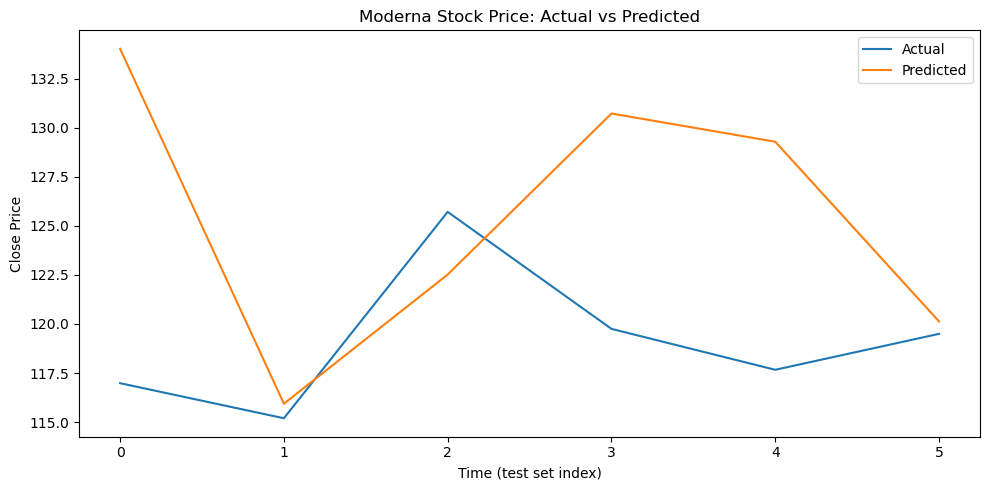

In [156]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Moderna Stock Price: Actual vs Predicted")
plt.xlabel("Time (test set index)")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# Moderna Only (LSTM)

In [157]:
# LSTM Model

# Create features and target
df_moderna = sim_df[sim_df['Company'] == 'Moderna'].copy()
df_moderna.sort_values('Date', inplace=True)
df_moderna.reset_index(drop=True, inplace=True)

# Feature engineering
df_moderna['Prev_Close'] = df_moderna['Close'].shift(1)
df_moderna['MA_3'] = df_moderna['Close'].rolling(window=3).mean()
df_moderna['MA_5'] = df_moderna['Close'].rolling(window=5).mean()
df_moderna['Range'] = df_moderna['High'] - df_moderna['Low']

# Target variable (next day's Close)
df_moderna['Target_Close'] = df_moderna['Close'].shift(-1)

# Drop rows with NaNs from shift and rolling
df_moderna.dropna(inplace=True)

In [158]:
# Normalize features
features = ['Open', 'High', 'Low', 'Volume', 'Market_Cap', 'PE_Ratio',
            'Dividend_Yield', 'Volatility', 'Sentiment_Score',
            'Prev_Close', 'MA_3', 'MA_5', 'Range']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_moderna[features])

y = df_moderna['Target_Close'].values

In [159]:
#Create sequences for LSTM
def create_sequences(X, y, window=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

X_lstm, y_lstm = create_sequences(X_scaled, y, window=5)

In [160]:
# Split the data into training and testing sets
split_index = int(len(X_lstm) * 0.8)

X_train_2, X_test_2 = X_lstm[:split_index], X_lstm[split_index:]
y_train_2, y_test_2 = y_lstm[:split_index], y_lstm[split_index:]

In [161]:
# Train the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_2.shape[1], X_train_2.shape[2]), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_2, y_train_2, epochs=50, batch_size=8, verbose=1)

Epoch 1/50


c:\Users\anitr\miniconda3\envs\AAI510\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 12945.0918 
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13013.4668
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12972.2871
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12905.3730
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 13007.5234
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12945.3721
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12934.8408
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12794.0322
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12855.9902
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12830.7129
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12856.6230
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 12734.4316
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12653.8311
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12671.4238
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - l

In [162]:
# Evaluate the LSTM model
y_pred_2 = model.predict(X_test_2).flatten()
lstm_mae = mean_absolute_error(y_test_2, y_pred_2)
lstm_rmse = np.sqrt(mean_squared_error(y_test_2, y_pred_2))

print(f"LSTM MAE:  {lstm_mae:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
LSTM MAE:  111.20
LSTM RMSE: 111.32


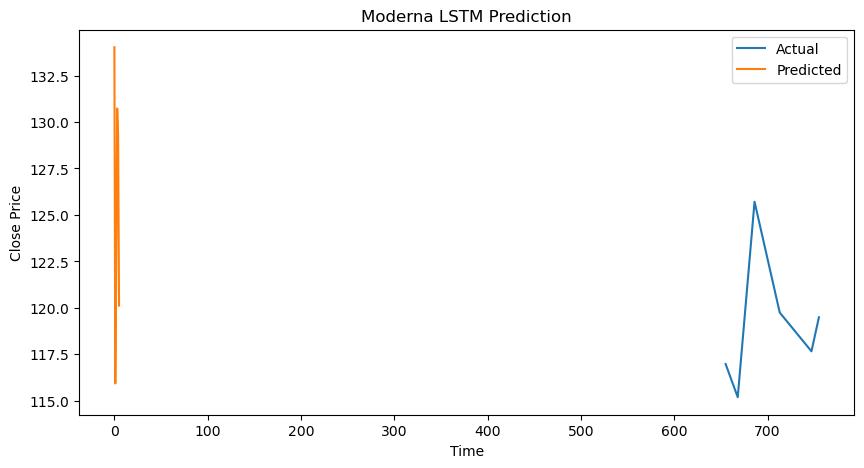

In [163]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Moderna LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [164]:
print(f"Linear Regression MAE:  {lr_mae:.2f}")
print(f"Linear Regression RMSE: {lr_rmse:.2f}")

print(f"LSTM MAE:  {lstm_mae:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}")


Linear Regression MAE:  7.37
Linear Regression RMSE: 9.64
LSTM MAE:  111.20
LSTM RMSE: 111.32


Linear regression performed better than LSTM prediciting closer to the actual closing prices. LSTM had high error, but dataset is very small (only 27 records).

## Moderna Only (Classification)

In [165]:
# Sort by date
df_moderna.sort_values('Date', inplace=True)
df_moderna.reset_index(drop=True, inplace=True)

In [166]:
# Create binary target variable for classification
df_moderna['Target'] = (df_moderna['Close'].shift(-1) > df_moderna['Close']).astype(int)
df_moderna.dropna(inplace=True) 


In [167]:
# Select features for classification
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap',
            'PE_Ratio', 'Dividend_Yield', 'Volatility', 'Sentiment_Score']

X = df_moderna[features]
y = df_moderna['Target']

In [168]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [169]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

In [170]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [171]:
print("Logistic Regression Results:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall:    {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.2f}")



Logistic Regression Results:
Accuracy:  0.40
Precision: 0.25
Recall:    1.00
F1 Score:  0.40


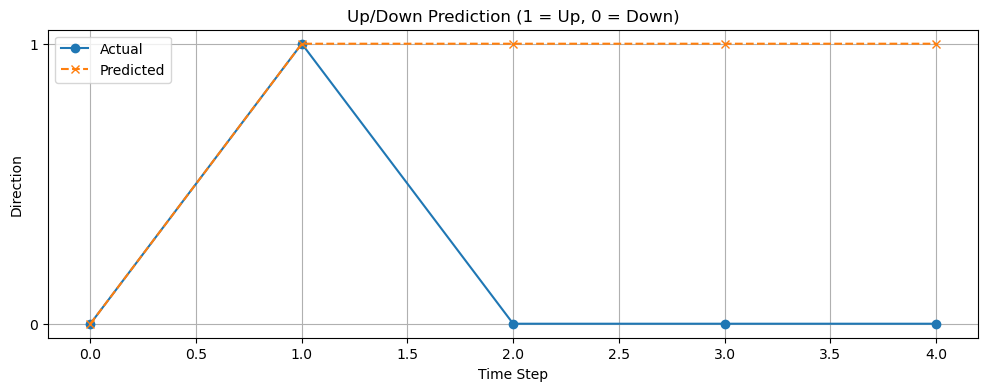

In [172]:
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred).reset_index(drop=True)

plt.figure(figsize=(12, 4))
plt.plot(y_test_reset[:30], label='Actual', marker='o')
plt.plot(y_pred_reset[:30], label='Predicted', linestyle='--', marker='x')
plt.title('Up/Down Prediction (1 = Up, 0 = Down)')
plt.xlabel('Time Step')
plt.ylabel('Direction')
plt.yticks([0, 1])
plt.legend()
plt.grid(True)
plt.show()

When trying a classification model (logistic regression), to see how it would do predicting whether the next-day closing stock prices would be up or down, the accuracy was low and precision were low, while recall high. The model predicted that the stock prices most of the time would go up but was often wrong. 